This script:

1. Loads both datasets
2. Withholds the 3 specified cruises from bottle data (~6%)
3. Finds date ranges and withholds corresponding CTD data (~3%)
4. Does stratified random sampling to bring both up to 10% evaluation
5. Saves 4 files: bottle_training, bottle_evaluation, CTD_training, CTD_evaluation

The stratification is by CRUISE_ID for bottle data and by year for CTD data.

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import glob

## Load Data

In [3]:
# Load bottle data
df_bottle = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/DFO_LineP_bottles.csv',comment='#')

# Load CTD data
df_ctd = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/DFO_LineP_CTDdata.csv',comment='#')

print(f"Original bottle data: {len(df_bottle)} rows")
print(f"Original CTD data: {len(df_ctd)} rows")

# Parse time columns
df_bottle['TIME'] = pd.to_datetime(df_bottle['TIME'])
df_ctd['TIME'] = pd.to_datetime(df_ctd['TIME'])


Original bottle data: 4983 rows
Original CTD data: 5815336 rows


In [4]:
df_ctd

,STATION_ID,TIME,LATITUDE,LONGITUDE,DEPTH,PRESSURE,PRESSURE_BIN_CENTER,TEMPERATURE,SALINITY,OXYGEN_MMOL_M3,OXYGEN_UMOL_KG
0,P26,1969-08-26 22:18:00,50.000000,-145.00000,0.000000,0.000000,0.5,12.3000,32.5200,NaN,NaN
1,P26,1969-08-26 22:18:00,50.000000,-145.00000,5.000000,5.043289,5.5,12.1500,32.5200,NaN,NaN
2,P26,1969-08-26 22:18:00,50.000000,-145.00000,10.000000,10.086701,10.5,12.1200,32.5200,NaN,NaN
3,P26,1969-08-26 22:18:00,50.000000,-145.00000,20.000001,20.173897,20.5,12.0700,32.5200,NaN,NaN
4,P26,1969-08-26 22:18:00,50.000000,-145.00000,26.000000,26.226450,26.5,12.0500,32.5200,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5815331,P17,2020-02-13 12:39:40,49.350166,-135.66684,1974.521684,2001.000000,2001.5,1.9819,34.5800,53.52,52.0
5815332,P17,2020-02-13 12:39:40,49.350166,-135.66684,1975.503826,2002.000000,2002.5,1.9802,34.5804,53.52,52.0
5815333,P17,2020-02-13 12:39:40,49.350166,-135.66684,1976.485963,2003.000000,2003.5,1.9801,34.5804,53.52,52.0
5815334,P17,2020-02-13 12:39:40,49.350166,-135.66684,1977.468096,2004.000000,2004.5,1.9800,34.5805,53.52,52.0


## 2. Withhold specific cruises (Bottle data)

In [5]:
eval_cruises = [2006.15, 2010.13, 2018.01]

# Separate evaluation cruises from bottle data
bottle_eval_cruises = df_bottle[df_bottle['CRUISE_ID'].isin(eval_cruises)].copy()
bottle_remaining = df_bottle[~df_bottle['CRUISE_ID'].isin(eval_cruises)].copy()

print(f"\nBottle eval cruises: {len(bottle_eval_cruises)} rows ({len(bottle_eval_cruises)/len(df_bottle)*100:.1f}%)")
print(f"Bottle remaining: {len(bottle_remaining)} rows")


Bottle eval cruises: 323 rows (6.5%)
Bottle remaining: 4660 rows


## 3. Find date ranges for eval cruises

In [6]:
df_bottle[df_bottle.DIC.isna()]

,CRUISE_ID,STATION_ID,TIME,LATITUDE,LONGITUDE,DEPTH,PRESSURE,TEMPERATURE,SALINITY,OXYGEN,DIC,TA,NITRATE,PHOSPHATE,SILICATE
68,1990.01,20,1990-05-14 15:36:00,49.57,-138.67,3874.000000,3943.616080,1.5300,34.6700,132.1,NaN,NaN,37.8,2.68,168.3
107,1990.01,26,1990-05-17 03:18:00,50.00,-145.00,246.000000,248.276068,3.9800,33.8280,98.0,NaN,NaN,37.8,2.78,74.0
108,1990.01,26,1990-05-17 03:18:00,50.00,-145.00,295.000000,297.765036,3.9400,33.8870,78.6,NaN,NaN,39.8,2.89,82.0
116,1990.01,26,1990-05-17 03:18:00,50.00,-145.00,1987.000000,2013.825302,1.9300,34.5860,58.9,NaN,NaN,42.4,3.05,167.4
143,1990.02,4,1990-08-23 18:51:00,48.65,-126.67,1301.000000,1316.236572,2.7500,34.4860,29.5,NaN,NaN,42.9,3.12,153.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4909,2019.06,4,2019-06-04 02:45:00,48.65,-126.66,1236.118597,1250.400000,2.8896,34.4812,21.7,NaN,NaN,43.1,3.09,NaN
4931,2019.06,12,2019-06-05 18:07:00,48.97,-130.67,2953.941376,3000.400000,1.6545,34.6464,NaN,NaN,NaN,40.1,2.82,NaN
4934,2019.06,12,2019-06-05 18:07:00,48.97,-130.67,3222.063857,3274.800000,1.6720,34.6478,NaN,NaN,NaN,NaN,NaN,NaN
4957,2019.06,20,2019-06-08 21:18:00,49.57,-138.66,3441.580945,3499.900000,1.5273,34.6694,121.5,NaN,NaN,38.1,2.65,NaN


In [7]:
date_ranges = []
for cruise in eval_cruises:
    cruise_data = bottle_eval_cruises[bottle_eval_cruises['CRUISE_ID'] == cruise]
    start_date = cruise_data['TIME'].min() - timedelta(days=2)
    end_date = cruise_data['TIME'].max() + timedelta(days=2)
    date_ranges.append((start_date, end_date))
    print(f"Cruise {cruise}: {start_date.date()} to {end_date.date()}")

Cruise 2006.15: 2006-09-21 to 2006-09-30
Cruise 2010.13: 2010-06-05 to 2010-06-15
Cruise 2018.01: 2018-02-19 to 2018-03-06


## 4. Withhold CTD data based on date ranges

In [8]:
ctd_eval_mask = pd.Series(False, index=df_ctd.index)
for start_date, end_date in date_ranges:
    mask = (df_ctd['TIME'] >= start_date) & (df_ctd['TIME'] <= end_date)
    ctd_eval_mask = ctd_eval_mask | mask

ctd_eval_cruises = df_ctd[ctd_eval_mask].copy()
ctd_remaining = df_ctd[~ctd_eval_mask].copy()

print(f"\nCTD eval cruises: {len(ctd_eval_cruises)} rows ({len(ctd_eval_cruises)/len(df_ctd)*100:.1f}%)")
print(f"CTD remaining: {len(ctd_remaining)} rows")


CTD eval cruises: 193860 rows (3.3%)
CTD remaining: 5621476 rows


## 5. Additional stratified random sampling to reach 10%

In [9]:
## 5. Additional stratified random sampling to reach 10%
def balanced_stratified_sample(df, strata_cols, n_samples, random_state=42):
    """
    Sample with inverse weighting to balance across strata
    """
    df = df.copy()
    np.random.seed(random_state)
    
    # Create combined strata
    df['strata'] = df[strata_cols[0]].astype(str)
    for col in strata_cols[1:]:
        df['strata'] = df['strata'] + '_' + df[col].astype(str)
    
    # Weight inversely to stratum size
    strata_sizes = df['strata'].value_counts()
    df['weight'] = df['strata'].map(lambda x: 1.0 / strata_sizes[x])
    df['weight'] = df['weight'] / df['weight'].sum()
    
    # Sample
    sampled_indices = np.random.choice(
        df.index, 
        size=min(n_samples, len(df)),
        replace=False,
        p=df['weight'].values
    )
    
    return df.loc[sampled_indices].drop(columns=['strata', 'weight'])

# Calculate additional samples needed for 10%
bottle_target_eval = int(len(df_bottle) * 0.10)
bottle_additional_needed = bottle_target_eval - len(bottle_eval_cruises)

ctd_target_eval = int(len(df_ctd) * 0.10)
ctd_additional_needed = ctd_target_eval - len(ctd_eval_cruises)

# Add year and month columns for stratification
bottle_remaining['YEAR'] = bottle_remaining['TIME'].dt.year
bottle_remaining['MONTH'] = bottle_remaining['TIME'].dt.month

ctd_remaining['YEAR'] = ctd_remaining['TIME'].dt.year
ctd_remaining['MONTH'] = ctd_remaining['TIME'].dt.month

print(f"\nBottle: sampling {bottle_additional_needed} more for 10% eval")
bottle_random_eval = balanced_stratified_sample(
    bottle_remaining, 
    ['YEAR', 'MONTH', 'STATION_ID'],
    bottle_additional_needed
)

print(f"\nCTD: sampling {ctd_additional_needed} more for 10% eval")
ctd_random_eval = balanced_stratified_sample(
    ctd_remaining,
    ['YEAR', 'MONTH', 'STATION_ID'],
    ctd_additional_needed
)

# Add year/month to eval cruise data for consistency
bottle_eval_cruises['YEAR'] = bottle_eval_cruises['TIME'].dt.year
bottle_eval_cruises['MONTH'] = bottle_eval_cruises['TIME'].dt.month
ctd_eval_cruises['YEAR'] = ctd_eval_cruises['TIME'].dt.year
ctd_eval_cruises['MONTH'] = ctd_eval_cruises['TIME'].dt.month

# Combine for final sets
bottle_evaluation = pd.concat([bottle_eval_cruises, bottle_random_eval], ignore_index=True)
bottle_training = bottle_remaining[~bottle_remaining.index.isin(bottle_random_eval.index)].copy()

ctd_evaluation = pd.concat([ctd_eval_cruises, ctd_random_eval], ignore_index=True)
ctd_training = ctd_remaining[~ctd_remaining.index.isin(ctd_random_eval.index)].copy()

# Clean up temporary columns
ctd_training = ctd_training.drop(columns=['YEAR', 'MONTH'], errors='ignore')
ctd_evaluation = ctd_evaluation.drop(columns=['YEAR', 'MONTH'], errors='ignore')
bottle_training = bottle_training.drop(columns=['YEAR', 'MONTH'], errors='ignore')
bottle_evaluation = bottle_evaluation.drop(columns=['YEAR', 'MONTH'], errors='ignore')


Bottle: sampling 175 more for 10% eval

CTD: sampling 387673 more for 10% eval


## 6. Verify split percentages

In [11]:
print(f"\n=== FINAL RESULTS ===")
print(f"Bottle training: {len(bottle_training)} rows ({len(bottle_training)/len(df_bottle)*100:.1f}%)")
print(f"Bottle evaluation: {len(bottle_evaluation)} rows ({len(bottle_evaluation)/len(df_bottle)*100:.1f}%)")
print(f"Total bottle: {len(bottle_training) + len(bottle_evaluation)} (should be {len(df_bottle)})")

print(f"\nCTD training: {len(ctd_training)} rows ({len(ctd_training)/len(df_ctd)*100:.1f}%)")
print(f"CTD evaluation: {len(ctd_evaluation)} rows ({len(ctd_evaluation)/len(df_ctd)*100:.1f}%)")
print(f"Total CTD: {len(ctd_training) + len(ctd_evaluation)} (should be {len(df_ctd)})")


=== FINAL RESULTS ===
Bottle training: 4485 rows (90.0%)
Bottle evaluation: 498 rows (10.0%)
Total bottle: 4983 (should be 4983)

CTD training: 5233803 rows (90.0%)
CTD evaluation: 581533 rows (10.0%)
Total CTD: 5815336 (should be 5815336)


## 7. Save files

In [ ]:
output_dir = '/home/sbeairsto/projects/line_p/data/observation/'

# Define header for saved files
bottle_header = """

# Description: Bottle samples collected as part of the DFO Line P cruise program 
# then corrected and distributed by Franco et al. 2021 (DOI: 10.1029/2020GB006829) 
# then pre-processed for the SD-Ocean Line P Hackathon in October 2025. 
# Temperature was measured by reversing therometer early in the record and salinity via bottle sample. 
# Temperature and salinity in the later part of the record are from CTD profiles. 
# Oxygen and DIC and TA and the nutrients are from bottle samples of seawater.  
# 
# Split method: 3 complete cruises (2006.15, 2010.13, 2018.01) + stratified random sampling to 10%
#
# Collection:
# CRUISE_ID label
#
# Coordinates:
# STATION_ID for Line P stations P4 to P26
# TIME in UTC between 1990 to 2019 
# LATITUDE in decimal degrees
# LONGITUDE in decimal degrees
# DEPTH in m
# PRESSURE in dbar
# 
# Variables: 
# TEMPERATURE in degrees Celcius (in-situ)
# SALINITY PSS-78
# OXYGEN in µmol/kg (dissolved oxygen)
# DIC in µmol/kg
# TA in µmol/kg
# NITRATE in µmol/kg (nitrate plus nitrite)
# PHOSPHATE in µmol/kg
# SILICATE in µmol/kg

"""

ctd_header = """
# Description: CTD casts/profiles collected as part of the DFO Line P cruise program 
# then extracted from waterproperties.ca by Amber Holdsworth, made available via 
# https://hpfx.collab.science.gc.ca/dfo/SD-Ocean/Training/observations/binned/, 
# and pre-processed for the SD-Ocean Line P Hackathon in October 2025. 
# Temperature, salinity, and oxygen are collected using sensors lowered through the 
# water column at or near Line P stations.  
# 
# Split method: Date ranges matching bottle eval cruises + stratified random sampling to 10%
#
# Coordinates:
# STATION_ID for Line P stations P4 to P26
# TIME in UTC between 1969 to 2020 
# LATITUDE in decimal degrees
# LONGITUDE in decimal degrees
# DEPTH in m
# PRESSURE in dbar
# PRESSURE_BIN_CENTER in dbar
# 
# Variables: 
# TEMPERATURE in degrees Celcius (in-situ)
# SALINITY PSS-78
# OXYGEN_MMOL_M3 in mmol/m^3 (dissolved oxygen)
# OXYGEN_UMOL_KG in µmol/kg (dissolved oxygen)
"""

# Save with headers
with open(f'{output_dir}bottle_training.csv', 'w') as f:
    f.write(bottle_header)
    bottle_training.to_csv(f, index=False)

with open(f'{output_dir}bottle_evaluation.csv', 'w') as f:
    f.write(bottle_header)
    bottle_evaluation.to_csv(f, index=False)

with open(f'{output_dir}CTD_training.csv', 'w') as f:
    f.write(ctd_header)
    ctd_training.to_csv(f, index=False)

with open(f'{output_dir}CTD_evaluation.csv', 'w') as f:
    f.write(ctd_header)
    ctd_evaluation.to_csv(f, index=False)

print(f"\nFiles saved to {output_dir}")


Files saved to /home/sbeairsto/projects/line_p/data/observation/



STRATIFICATION CHECK: BOTTLE DATA

Total strata: 212
Mean eval proportion: 0.103
Std eval proportion: 0.242
Min eval proportion: 0.000
Max eval proportion: 1.000

Top 5 strata furthest from 10% eval:
dataset    training  evaluation  total  eval_prop
strata                                           
2006_9_12         0          23     23        1.0
2006_9_16         0          24     24        1.0
2006_9_20         0          24     24        1.0
2006_9_26         0          24     24        1.0
2010_6_12         0          23     23        1.0

--- Breakdown by YEAR ---
dataset  training  evaluation  total  eval_prop
YEAR                                           
1990          250           8    258   0.031008
1991           26           2     28   0.071429
1992          267          10    277   0.036101
1993          109           6    115   0.052174
1994          164           5    169   0.029586
1995           63           1     64   0.015625
1996          243          14    257  

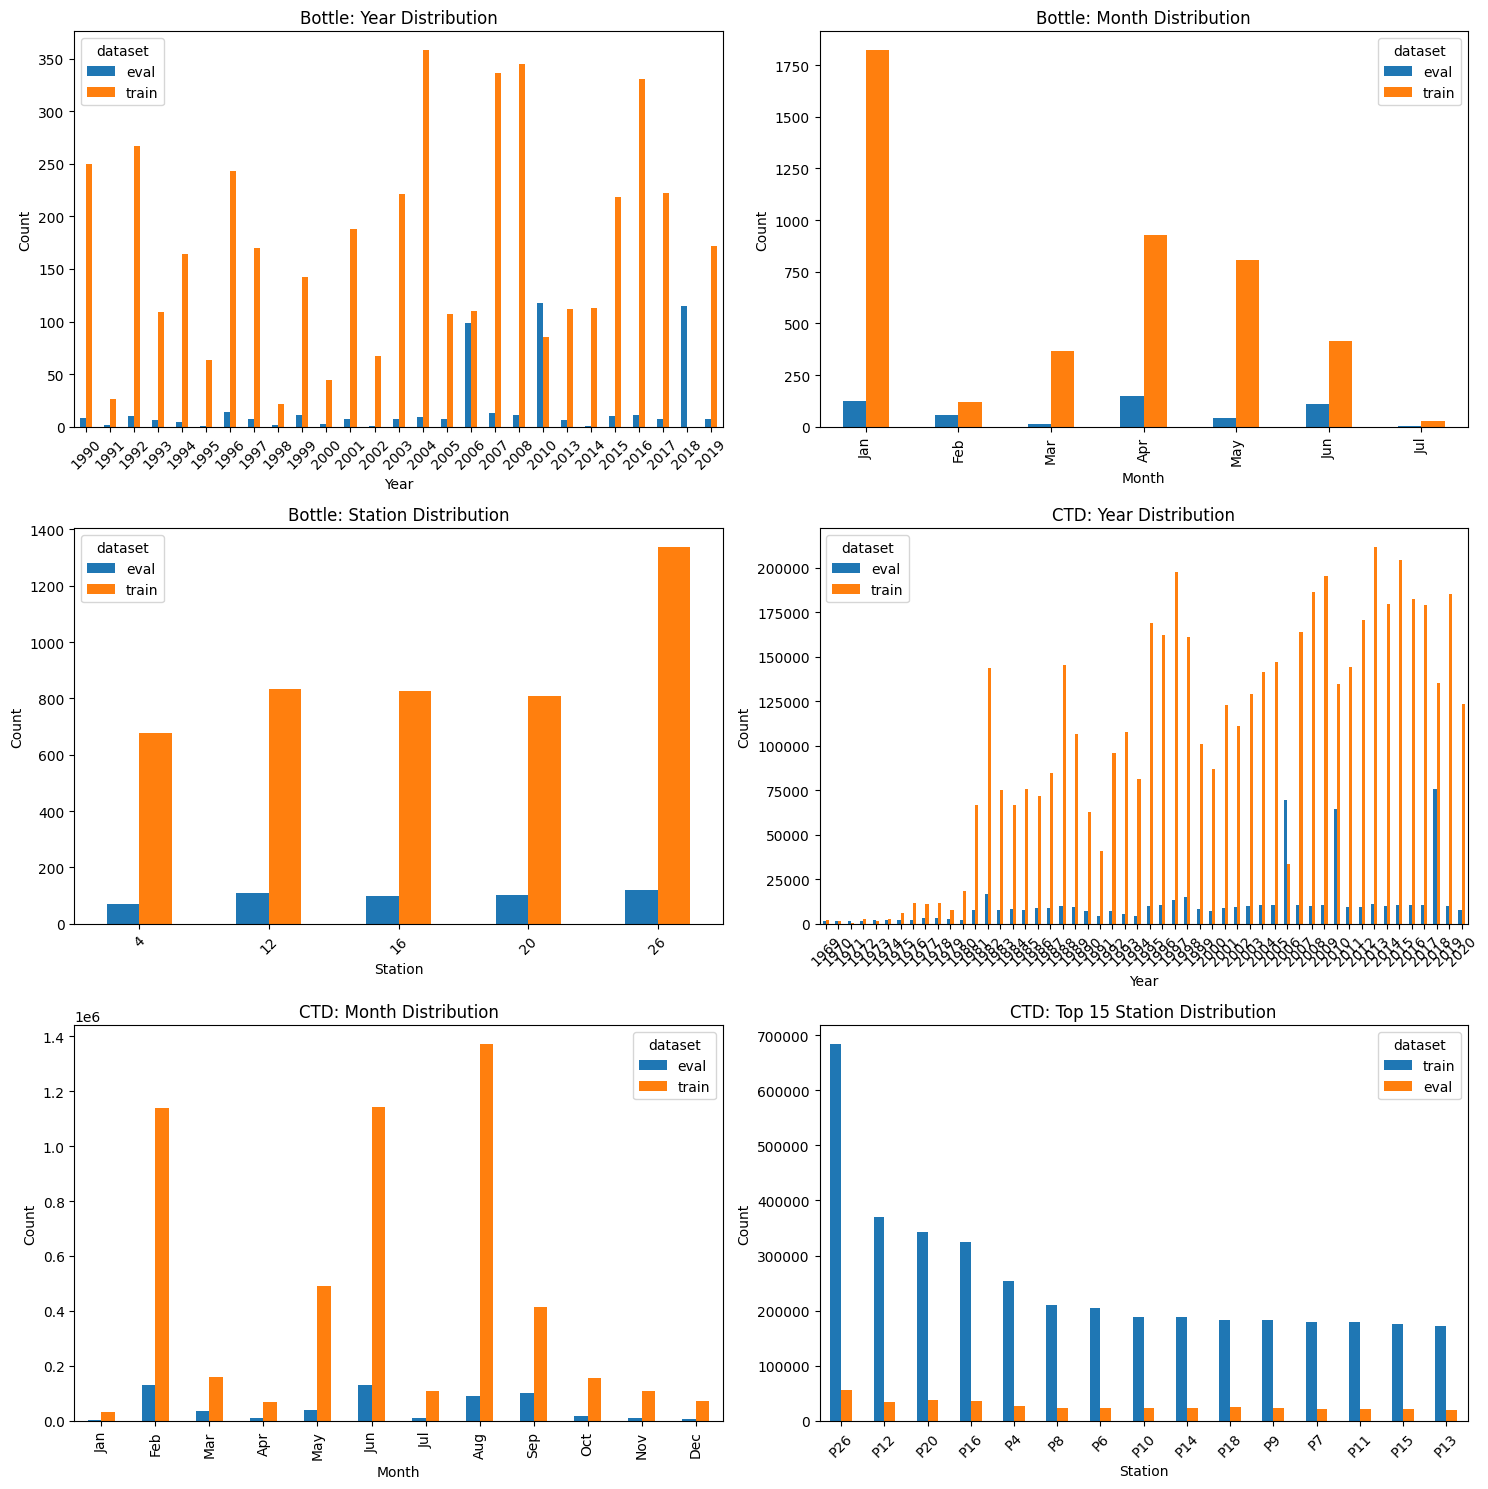

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# VERIFY STRATIFICATION
# ============================================================================

def check_stratification(training, evaluation, strata_cols, dataset_name):
    """
    Check if evaluation set has similar proportions to training set across strata
    """
    print(f"\n{'='*60}")
    print(f"STRATIFICATION CHECK: {dataset_name}")
    print(f"{'='*60}")
    
    # Combine datasets with labels
    training_copy = training.copy()
    evaluation_copy = evaluation.copy()
    training_copy['dataset'] = 'training'
    evaluation_copy['dataset'] = 'evaluation'
    combined = pd.concat([training_copy, evaluation_copy])
    
    # Create strata column
    combined['strata'] = combined[strata_cols[0]].astype(str)
    for col in strata_cols[1:]:
        combined['strata'] = combined['strata'] + '_' + combined[col].astype(str)
    
    # Calculate proportions
    strata_counts = combined.groupby(['strata', 'dataset']).size().unstack(fill_value=0)
    strata_counts['total'] = strata_counts.sum(axis=1)
    strata_counts['train_prop'] = strata_counts['training'] / strata_counts['total']
    strata_counts['eval_prop'] = strata_counts['evaluation'] / strata_counts['total']
    strata_counts['difference'] = abs(strata_counts['eval_prop'] - 0.10)
    
    print(f"\nTotal strata: {len(strata_counts)}")
    print(f"Mean eval proportion: {strata_counts['eval_prop'].mean():.3f}")
    print(f"Std eval proportion: {strata_counts['eval_prop'].std():.3f}")
    print(f"Min eval proportion: {strata_counts['eval_prop'].min():.3f}")
    print(f"Max eval proportion: {strata_counts['eval_prop'].max():.3f}")
    
    # Show strata with largest deviations from 10%
    print(f"\nTop 5 strata furthest from 10% eval:")
    print(strata_counts.nlargest(5, 'difference')[['training', 'evaluation', 'total', 'eval_prop']])
    
    # Summary by individual stratification variables
    for col in strata_cols:
        print(f"\n--- Breakdown by {col} ---")
        col_summary = combined.groupby([col, 'dataset']).size().unstack(fill_value=0)
        col_summary['total'] = col_summary.sum(axis=1)
        col_summary['eval_prop'] = col_summary['evaluation'] / col_summary['total']
        print(col_summary[['training', 'evaluation', 'total', 'eval_prop']])
    
    return strata_counts

# Load data (skip comment lines)
bottle_training = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/bottle_training.csv', comment='#')
bottle_evaluation = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/bottle_evaluation.csv', comment='#')
ctd_training = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/CTD_training.csv', comment='#')
ctd_evaluation = pd.read_csv('/home/sbeairsto/projects/line_p/data/observation/CTD_evaluation.csv', comment='#')

# Parse time columns and add year/month
for df in [bottle_training, bottle_evaluation, ctd_training, ctd_evaluation]:
    df['TIME'] = pd.to_datetime(df['TIME'])
    df['YEAR'] = df['TIME'].dt.year
    df['MONTH'] = df['TIME'].dt.month

# Check stratification
bottle_strata = check_stratification(
    bottle_training, 
    bottle_evaluation, 
    ['YEAR', 'MONTH', 'STATION_ID'],
    'BOTTLE DATA'
)

ctd_strata = check_stratification(
    ctd_training, 
    ctd_evaluation, 
    ['YEAR', 'MONTH', 'STATION_ID'],
    'CTD DATA'
)

# ============================================================================
# VISUALIZE STRATIFICATION
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Bottle: Year distribution
bottle_year = pd.concat([bottle_training.assign(dataset='train'), 
                         bottle_evaluation.assign(dataset='eval')])
bottle_year_counts = bottle_year.groupby(['YEAR', 'dataset']).size().unstack(fill_value=0)
bottle_year_counts.plot(kind='bar', ax=axes[0,0], title='Bottle: Year Distribution')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Bottle: Month distribution
bottle_month_counts = bottle_year.groupby(['MONTH', 'dataset']).size().unstack(fill_value=0)
bottle_month_counts.plot(kind='bar', ax=axes[0,1], title='Bottle: Month Distribution')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Count')
axes[0,1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(bottle_month_counts)])

# Bottle: Station distribution
bottle_station_counts = bottle_year.groupby(['STATION_ID', 'dataset']).size().unstack(fill_value=0)
bottle_station_counts.plot(kind='bar', ax=axes[1,0], title='Bottle: Station Distribution')
axes[1,0].set_xlabel('Station')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# CTD: Year distribution
ctd_year = pd.concat([ctd_training.assign(dataset='train'), 
                      ctd_evaluation.assign(dataset='eval')])
ctd_year_counts = ctd_year.groupby(['YEAR', 'dataset']).size().unstack(fill_value=0)
ctd_year_counts.plot(kind='bar', ax=axes[1,1], title='CTD: Year Distribution')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)

# CTD: Month distribution
ctd_month_counts = ctd_year.groupby(['MONTH', 'dataset']).size().unstack(fill_value=0)
ctd_month_counts.plot(kind='bar', ax=axes[2,0], title='CTD: Month Distribution')
axes[2,0].set_xlabel('Month')
axes[2,0].set_ylabel('Count')
axes[2,0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(ctd_month_counts)])

# CTD: Station distribution
ctd_station_counts = ctd_year.groupby(['STATION_ID', 'dataset']).size().unstack(fill_value=0)
ctd_station_counts['total'] = ctd_station_counts.sum(axis=1)
ctd_station_counts.nlargest(15, 'total')[['train', 'eval']].plot(kind='bar', ax=axes[2,1], 
                                                                   title='CTD: Top 15 Station Distribution')
axes[2,1].set_xlabel('Station')
axes[2,1].set_ylabel('Count')
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/home/sbeairsto/projects/line_p/data/observation/stratification_check.png', dpi=150, bbox_inches='tight')
print("\nPlot saved to: /home/sbeairsto/projects/line_p/data/observation/stratification_check.png")